# 小測試正確率

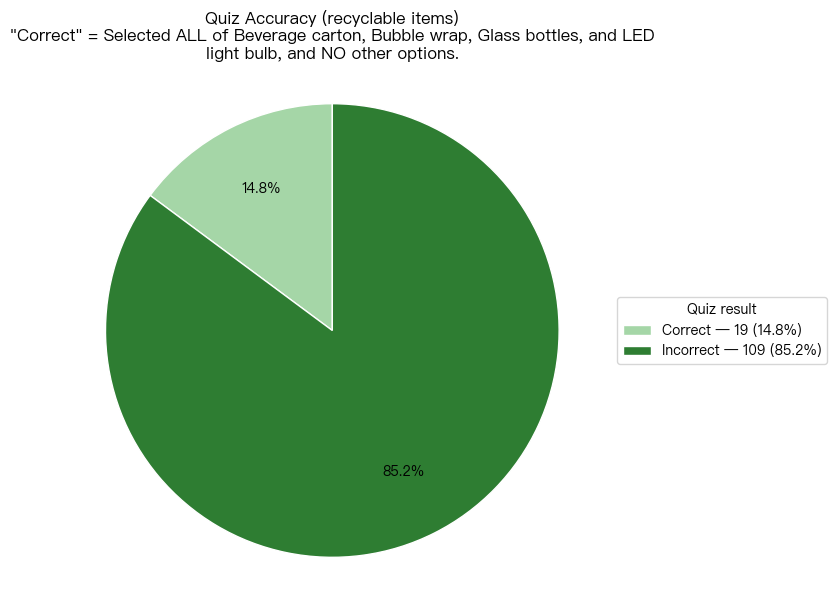

In [7]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from textwrap import wrap

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- locate the Q3 multi-select column ----------
patterns = [
    r"identify\s+which\s+of\s+the\s+following\s+item\(s\)\s+can\s+be\s+recycled\s+at\s+green@community\s+facilities",
    r"請指出下列哪些物品可以在.*綠在區區.*設施進行回收",
]

def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    # try explicit patterns first
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    # fallback heuristic
    for c, norm in cols:
        if re.search(r"green@community", norm, flags=re.IGNORECASE) and \
           re.search(r"recycl", norm, flags=re.IGNORECASE):
            return c
    return None

items_col = find_col(df.columns, patterns)
if items_col is None:
    raise RuntimeError("Could not find the recyclable-items checkbox column for Q3.")

series = df[items_col].fillna("").astype(str)

# ---------- parse each response into a set of chosen options ----------
def parse_items(cell: str):
    # split by comma, keep cleaned choice names from the CLEANED DATA
    return {part.strip() for part in cell.split(",") if part.strip()}

parsed_sets = series.apply(parse_items)

# ---------- define the correct answer set (using cleaned-data labels) ----------
correct_items = [
    "Beverage carton",
    "Bubble wrap",
    "Glass bottles",
    "LED light bulb",
]

def norm(s: str) -> str:
    return s.strip().lower()

correct_norm = {norm(x) for x in correct_items}

# function to normalise a respondent's set
def normalised_set(s: set) -> set:
    return {norm(x) for x in s}

# ---------- classify each respondent as Correct / Incorrect ----------
is_correct = parsed_sets.apply(lambda s: normalised_set(s) == correct_norm)

n_total     = int(len(is_correct))
n_correct   = int(is_correct.sum())
n_incorrect = int(n_total - n_correct)

counts = [n_correct, n_incorrect]
labels = ["Correct", "Incorrect"]

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- build legend labels with counts + percentages ----------
pct = [(c / n_total * 100) if n_total > 0 else 0.0 for c in counts]
legend_labels = [
    f"{labels[i]} — {counts[i]} ({pct[i]:.1f}%)" for i in range(len(labels))
]

# ---------- plot pie chart (white background, no overlaps) ----------
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
ax.set_facecolor("white")

# colours: green for correct, grey for incorrect
colors = ["#a5d6a7", "#2e7d32"]

wedges, text_labels, autotexts = ax.pie(
    counts,
    labels=None,  # use legend instead
    colors=colors,
    startangle=90,
    autopct=(lambda p: f"{p:.1f}%") if n_total > 0 else None,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor="white"),
)

ax.legend(
    wedges,
    legend_labels,
    title="Quiz result",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
)

title_main = "Quiz Accuracy (recyclable items)"
title_sub  = ('"Correct" = Selected ALL of '
              'Beverage carton, Bubble wrap, Glass bottles, and LED light bulb, '
              'and NO other options.')
wrapped_sub = "\n".join(wrap(title_sub, 80))

ax.set_title(title_main + "\n" + wrapped_sub, pad=16)

ax.axis("equal")  # keep the pie circular
plt.tight_layout()
plt.show()
